<a href="https://colab.research.google.com/github/mukamal/recommender-system-shakespeare/blob/main/recommender_system_shakespeare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Shakespeare Recommender System

William Shakespeare is considered one of the greatest playwrights in the English language. He is attributed with 38 plays, 154 sonnets, and other works. Even 400 years later, his writings are still be studied in most high schools and colleges in the US and elsewhere. Shakespeare’s complete works are available online at http://shakespeare.mit.edu/.  We will be using a data set which has Shakespeare character quotes.  A lot of people are fascinated by the characters in the Shakespeare plays.  The first first part of the project is to create a Shakespeare character recommender system which is capable of recommending new characters which are similar to a speicific character of interest.  We will also explore using PCA inference to find important words in character quotes.  In the second part of the project we will use K-Means clustering to try and find one or more character insights. 

In [ ]:
%%bash
# Need to install pyspark
# if pyspark is already installed, will print a message indicating pyspark already isntalled
pip install pyspark

# Download the data files from github
# If the data file does bgtxnot exist in the colab environment
if [[ ! -f ./quotes_by_char.csv ]]; then 
   # download the data file from github and save it in this colab environment instance
   wget https://raw.githubusercontent.com/mukamal/data/main/quotes_by_char.csv  
fi

Processing /root/.cache/pip/wheels/0b/90/c0/01de724414ef122bd05f056541fb6a0ecf47c7ca655f8b3c0f/pyspark-3.1.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/9e/b6/6a4fb90cd235dc8e265a6a2067f2a2c99f0d91787f06aca4bcf7c23f3f80/py4j-0.10.9-py2.py3-none-any.whl


--2021-04-22 23:36:10--  https://raw.githubusercontent.com/mukamal/data/main/quotes_by_char.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4352265 (4.2M) [text/plain]
Saving to: ‘quotes_by_char.csv’

     0K .......... .......... .......... .......... ..........  1% 3.91M 1s
    50K .......... .......... .......... .......... ..........  2% 3.79M 1s
   100K .......... .......... .......... .......... ..........  3% 49.0M 1s
   150K .......... .......... .......... .......... ..........  4% 4.39M 1s
   200K .......... .......... .......... .......... ..........  5% 12.5M 1s
   250K .......... .......... .......... .......... ..........  7% 71.3M 1s
   300K .......... .......... .......... .......... ..........  8% 67.0M 0s
   350K .......... .......... .


Reading quotes_by_char.csv file into a spark dataframe named `quotes_by_char_df`.  Drop the `Unnamed` column.  

Transforming the character column such that all character names are lower case.

In [ ]:

# import statements
from pyspark.sql.functions import lower, col
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
#spark = SparkSession.builder.getOrCreate()




spark = SparkSession \
  .builder \
  .master("local[*]")\
  .config("spark.memory.fraction", 0.8) \
  .config("spark.executor.memory", "12g") \
  .config("spark.driver.memory", "12g")\
  .config("spark.memory.offHeap.enabled",'true')\
  .config("spark.memory.offHeap.size","12g")\
  .getOrCreate()


sc = spark.sparkContext
sqlContext = SQLContext(sc)


quotes_by_char_df = spark.read.format("csv").option("header", "true").load("quotes_by_char.csv")

#Drop the Unnamed column
quotes_by_char_df=quotes_by_char_df.drop('_c0')

#Transform the character column such that all character names are lower case.

quotes_by_char_df.dtypes
quotes_by_char_df=quotes_by_char_df.withColumn('character', lower(col('character')))
quotes_by_char_df.take(5)


[Row(character='& c', all_quotes='Well met, Master Ford. '),
 Row(character='a lord', all_quotes='Sir, it was I. '),
 Row(character='a patrician', all_quotes="This man has marr'd his fortune. You do the nobler. Ay, and burn too. "),
 Row(character='a player', all_quotes="So please your lordship to accept our duty. I think 'twas Soto that your honour means. Fear not, my lord: we can contain ourselves, Were he the veriest antic in the world. "),
 Row(character='aaron', all_quotes="Now climbeth Tamora Olympus' top, Safe out of fortune's shot; and sits aloft, Secure of thunder's crack or lightning flash; Advanced above pale envy's threatening reach. As when the golden sun salutes the morn, And, having gilt the ocean with his beams, Gallops the zodiac in his glistering coach, And overlooks the highest-peering hills; So Tamora: Upon her wit doth earthly honour wait, And virtue stoops and trembles at her frown. Then, Aaron, arm thy heart, and fit thy thoughts, To mount aloft with thy imperial

In [ ]:
display(quotes_by_char_df.toPandas().head())

,character,all_quotes
0,& c,"Well met, Master Ford."
1,a lord,"Sir, it was I."
2,a patrician,This man has marr'd his fortune. You do the no...
3,a player,So please your lordship to accept our duty. I ...
4,aaron,"Now climbeth Tamora Olympus' top, Safe out of ..."



Creating spark pipeline named `pipe_pca_1` which performs Principal Component Analysis (PCA) on `chars_df`.  

Using `pipe_pca_1` to create a new dataframe named `chars_pca_df`.  

Analyzing the resulting number of TF-IDF data rows and columns in the data. 


Using the analysis for the number of rows and cols in the data, explicitly set the K parameter in the spark PCA object equal to the maximum number of principal components.  


In [ ]:
from pyspark.ml import feature, regression, evaluation, Pipeline
from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import PCA
from pyspark.ml.feature import RegexTokenizer
from pyspark.ml.feature import IDF
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.feature import Normalizer
import requests
stop_words = requests.get('http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words').text.split()

tokenizer = RegexTokenizer().setGaps(False)\
  .setPattern("\\p{L}+")\
  .setInputCol("all_quotes")\
  .setOutputCol("words")

sw_filter = StopWordsRemover()\
  .setStopWords(stop_words)\
  .setCaseSensitive(False)\
  .setInputCol("words")\
  .setOutputCol("filtered")

#choose vocabSize
cv = CountVectorizer(minTF=4., minDF=10.)\
  .setInputCol("filtered")\
  .setOutputCol("tf")

idf = IDF().\
    setInputCol('tf').\
    setOutputCol('tfidf')
cnorm= Normalizer(inputCol='tfidf', outputCol='norm_tfidf')
cScale=StandardScaler(withMean=True,inputCol='norm_tfidf', outputCol='ztfidf')

pca=PCA(k=500, inputCol='ztfidf', outputCol='scores')


#pipeline should tokenize, remove stop words, and do a TF-IDF transformation

pipe_pca_1 = Pipeline(stages=[tokenizer, sw_filter, cv, idf,cnorm,cScale,pca]).fit(quotes_by_char_df)

chars_pca_df=pipe_pca_1.transform(quotes_by_char_df)


In [ ]:

print('num of rows of TF-IDF data',len(chars_pca_df.select('tfidf').toPandas()))
print('num of cols of TF-IDF data',len(pipe_pca_1.stages[2].vocabulary))
#sum(pipe_pca_1.stages[-1].explainedVariance)


num of rows of TF-IDF data 966
num of cols of TF-IDF data 4375


In [ ]:
display(chars_pca_df.toPandas().head())

,character,all_quotes,words,filtered,tf,tfidf,norm_tfidf,ztfidf,scores
0,& c,"Well met, Master Ford.","[well, met, master, ford]","[met, master, ford]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.5169884259207332, -0.48105111841410986, -0...","[0.8455151149229007, -1.4659754605126278, -1.2..."
1,a lord,"Sir, it was I.","[sir, it, was, i]",[sir],"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.5169884259207332, -0.48105111841410986, -0...","[0.8455151149229007, -1.4659754605126278, -1.2..."
2,a patrician,This man has marr'd his fortune. You do the no...,"[this, man, has, marr, d, his, fortune, you, d...","[man, marr, d, fortune, nobler, ay, burn]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.5169884259207332, -0.48105111841410986, -0...","[0.8455151149229007, -1.4659754605126278, -1.2..."
3,a player,So please your lordship to accept our duty. I ...,"[so, please, your, lordship, to, accept, our, ...","[lordship, accept, duty, think, twas, soto, ho...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.5169884259207332, -0.48105111841410986, -0...","[0.8455151149229007, -1.4659754605126278, -1.2..."
4,aaron,"Now climbeth Tamora Olympus' top, Safe out of ...","[now, climbeth, tamora, olympus, top, safe, ou...","[climbeth, tamora, olympus, safe, fortune, s, ...","(26.0, 16.0, 20.0, 18.0, 13.0, 12.0, 0.0, 5.0,...","(22.30907472962846, 19.21400365250883, 23.0122...","(0.14356901542390063, 0.12365082909863309, 0.1...","[0.44564187767991575, 0.5168019703272663, 0.63...","[-0.503244789914669, 2.2005424741768778, 3.074..."



Analyze the PCA data in `chars_pca_df`.  

Create scree and cumulative variance explained plots

Text(0, 0.5, 'Cumulative Sum of Variance Explained')

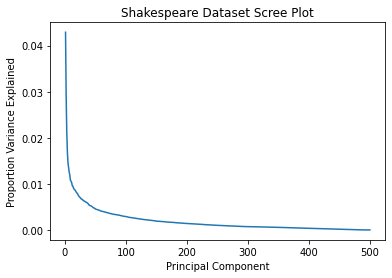

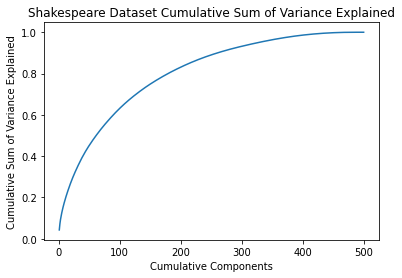

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# "scree plot"
plt.figure()
explained_var = pipe_pca_1.stages[-1].explainedVariance
plt.plot(np.arange(1, len(explained_var)+1), explained_var)
plt.title("Shakespeare Dataset Scree Plot")
plt.xlabel("Principal Component")
plt.ylabel("Proportion Variance Explained")



#the explained variance - plot
cum_sum = np.cumsum(explained_var)
plt.figure()
plt.plot(np.arange(1, len(explained_var)+1), cum_sum)
plt.title("Shakespeare Dataset Cumulative Sum of Variance Explained")
plt.xlabel("Cumulative Components")
plt.ylabel("Cumulative Sum of Variance Explained")

With **150** principal components, we get **90%** of explained variance. Which should be sufficient enough for our use.

Code to make recommendations on new characters to study based on a specific character that a Shakespeare fan likes.

Create a function named get_nearest_chars that takes 2 arguments: char and num_nearest_chars. The char arg is a string which defines the character for which we are interested in finding similar characters. 

The num_nearest_chars arg is an integer that defines the total number of nearest characters which we want included in the return list. The get_nearest_chars function shall perform all of its internal operations in spark and return a python list containing a string corresponding to each of the nearest characters defined by num_nearest_chars. Compute the list of characterss which are closest to the char arg using L2 Euclidian distance. 


In [ ]:
from math import sqrt
import pandas as pd
import numpy as np


pca2=PCA(k=2, inputCol='ztfidf', outputCol='scores')
pipe_pca_2 = Pipeline(stages=[tokenizer, sw_filter, cv, idf,cnorm,cScale,pca2]).fit(quotes_by_char_df)
chars_pca_df_2=pipe_pca_2.transform(quotes_by_char_df)


pca_model = pipe_pca_2.stages[-1]
#pc1 = pca_model.pc.toArray()[:, 0].tolist()
#pc2 = pca_model.pc.toArray()[:, 1].tolist()


character = quotes_by_char_df.select('character').rdd.map(lambda x: x['character']).collect()
X = np.array(chars_pca_df_2.select('scores').rdd.map(lambda x: x['scores']).collect())


#print("X.shape:", X.shape)
def get_nearest_chars(char,num_nearest_chars):

  if (char not in character):
    print("Character not found in the list")
    return
  if (num_nearest_chars >= len(character) or num_nearest_chars<=0):
    print("num_nearest_chars is not valid")
    return

  c=character.index(char)
  corr=[]
  [corr.append(sqrt((X[i][0]-X[c][0])**2+(X[i][1]-X[c][1])**2)) for i in range(len(character))]

  final = pd.DataFrame({'char': character, 'corr': corr})
  final_list=final.nsmallest(num_nearest_chars+1, 'corr')
  return list(final_list['char'][1:])



In [ ]:
print(get_nearest_chars('romeo', 5))
print(get_nearest_chars('juliet', 5))

['buckingham', 'macbeth', 'queen margaret', 'duke vincentio', 'york']
['prospero', 'coriolanus', 'henry bolingbroke', 'leontes', 'king lear']


In [ ]:
print(get_nearest_chars('!*!@', 5))
print(get_nearest_chars('romeo', 1000000))
print(get_nearest_chars(1, 1000000))
# print(get_nearest_chars('romeo', 'romeo'))
print(get_nearest_chars('romeo', -1))

Character not found in the list
None
num_nearest_chars is not valid
None
Character not found in the list
None
num_nearest_chars is not valid
None



Using PCA score data from PC1 and PC2, create a 2 dimensional character visualization plot which shows what characters are similar to the `juliet` character.  

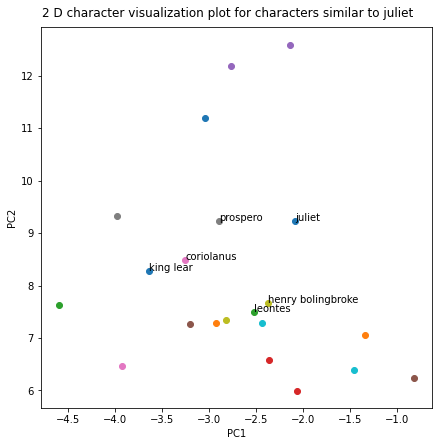

None

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(7)
#ax.scatter(X[:,0], X[:,1])
fig.suptitle("2 D character visualization plot for characters similar to juliet ", y=.92)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
x=0

c=character.index('juliet')
ax.scatter(X[c,0], X[c,1])
ax.annotate('juliet', (X[c,0], X[c,1]))



for i, txt in enumerate(character):
    if txt in get_nearest_chars('juliet', 20):

      ax.scatter(X[i,0], X[i,1])


for i, txt in enumerate(character):
    if txt in get_nearest_chars('juliet', 5):
      ax.annotate(txt, (X[i,0], X[i,1]))
      #ax.scatter(X[i,0], X[i,1])
      #print(txt)
#print(x)
    
display(plt.show())



Perform an inference analysis on the 10 most and 10 least important words in the data set as defined by the absolute value of the PC1 loading vector coefficients.  

Present the data by loading and printing 2 Pandas data frames containing the 10 most important words and 10 least important words named `most_imp_df` and `least_imp_df` respectively.

The data frames shall have 2 columns named `word` and `loading`.  

In [ ]:

pca_model = pipe_pca_2.stages[-1]
pc1 = pca_model.pc.toArray()[:, 0].tolist()
pc2 = pca_model.pc.toArray()[:, 1].tolist()

vocabulary = pipe_pca_2.stages[2].vocabulary
pc_loadings = pd.DataFrame([vocabulary, pc1]).T.rename(columns={0: 'word', 1: 'load_pc1'})
#print(pc_loadings.shape)


most_imp_df=pc_loadings.sort_values('load_pc1').\
    apply({'word': lambda x: x, 'load_pc1': np.abs}, axis=0).head(10)

least_imp_df=pc_loadings.sort_values('load_pc1').\
    apply({'word': lambda x: x, 'load_pc1': np.abs}, axis=0).tail(10)    



In [ ]:
display(most_imp_df)
display(least_imp_df)

,word,load_pc1
2460,lads,0.12472
2331,penny,0.12472
3033,shrewsbury,0.12472
1356,lean,0.12472
1671,rob,0.12472
2646,rogues,0.12472
1259,burning,0.12472
632,ta,0.12472
3620,hook,0.12472
2573,ragged,0.12472


,word,load_pc1
3763,thorough,0.000448663
2571,est,0.000448663
1594,bite,0.000451705
1464,horn,0.000473645
1977,sisters,0.000497275
1363,pyramus,0.000514782
76,madam,0.000531132
503,don,0.00058265
1330,macbeth,0.000601497
871,wall,0.000771207


The higher the absolute value of the PC loading vector coefficients, the higher the significance of the particular feature in the given principal component (which in this case is PC1)

#K-Means Clustering

Use the `chars_pca_df` from  above and compute K-Means silhouette scores for K = 2 through 6 on the PCA score data. 
 

Train your model on each K 3 times to find the lowest silhouette score.  The silhouette score is a measure of within cluster variation.  Remember that because K-Means starts out with random cluster assignments, it is not guaranteed to find a global minima so you should make multiple runs to find the lowest score.  Plot the silhouette scores vs. K and report the lowest silhouette score from the plot. If the process of finding the lowest silhouette scores is taking too much time, reduce the number of PCA score columns such that you capture a reasonable amount of variance but complete training in a more reasonable amount of time. 

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml import clustering
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
# Shows the result.
#centers = pipe_pca_3.stages[-1].clusterCenters()
#print("Cluster Centers: ")
#for center in centers:
#    print(center)
pca=PCA(k=150, inputCol='ztfidf', outputCol='scores')
means = clustering.KMeans(k=5, featuresCol='scores')

grid = ParamGridBuilder().\
    addGrid(means.k, [2, 3, 4,5,6]).\
    build()


all_models1 = []
#all_models2 = []
#all_models3 = []



for j in range(len(grid)):
    print("Fitting model {}".format(j+1))
    #model = lr_pipe_1.fit(training_df, grid[j])
    

    means = clustering.KMeans(k=j+2, featuresCol='scores').setSeed(j)
    model = Pipeline(stages=[tokenizer, sw_filter, cv, idf,cnorm,cScale,pca,means]).fit(quotes_by_char_df,grid[j])
    all_models1.append(model)
    
    #means = clustering.KMeans(k=j+2, featuresCol='scores').setSeed(j)
    #model2 = Pipeline(stages=[tokenizer, sw_filter, cv, idf,cnorm,cScale,pca,means]).fit(quotes_by_char_df,grid[j])
    #all_models2.append(model2)
    
    #means = clustering.KMeans(k=j+2, featuresCol='scores').setSeed(j)
    #model3 = Pipeline(stages=[tokenizer, sw_filter, cv, idf,cnorm,cScale,pca,means]).fit(quotes_by_char_df,grid[j])
    #all_models3.append(model3)        





Fitting model 1
Fitting model 2
Fitting model 3
Fitting model 4
Fitting model 5


In [ ]:

evaluator = ClusteringEvaluator(featuresCol='scores')


silhouettes1 = [ evaluator.evaluate(m.transform(quotes_by_char_df)) for m in all_models1]
print("silhouettes of the all the mdoels1:",silhouettes1)
#silhouettes2 = [ evaluator.evaluate(m.transform(quotes_by_char_df)) for m in all_models2]
#print("silhouettes of the all the mdoels2:",silhouettes2)
#silhouettes3 = [ evaluator.evaluate(m.transform(quotes_by_char_df)) for m in all_models3]
#print("silhouettes of the all the mdoels3:",silhouettes3)

silhouettes of the all the mdoels1: [0.9665046281618985, 0.9129357986445644, 0.8207917606733911, 0.8727517784962754, 0.4705775645594184]


Perform K-Means clustering using the `chars_pca_df` and plot the results using a scatter plot.  

Color the points by cluster assignment.  

The goal is to try to find an interesting insight about the Shakespeare characters.  For example, perhaps you spot one or more outlier characters that stands apart from the rest of the characters in the cluster.  

Text(0, 0.5, 'PC2')

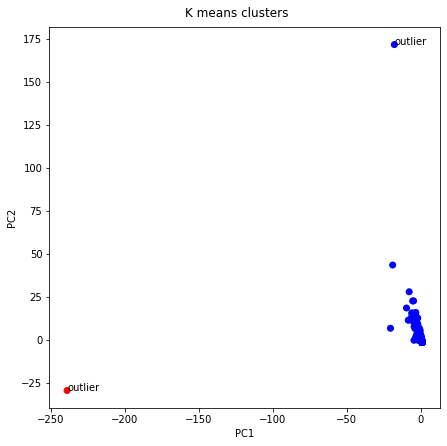

In [ ]:
predictions_2=all_models1[0].transform(quotes_by_char_df)

X_2 = np.array(predictions_2.select('scores').rdd.map(lambda x: x['scores']).collect())
k=np.array(predictions_2.select('prediction').rdd.map(lambda x: x['prediction']).collect())
k_mean_df = pd.DataFrame({'x': X_2[:,0], 'y': X_2[:,1],'k':k})

colors = np.where(k==1,'r','b')

fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(7)
ax.scatter(X_2[:,0], X_2[:,1],c=colors)
o1=k_mean_df.sort_values('x').head(1)
o2=k_mean_df.sort_values('y').tail(1)

ax.annotate('outlier', (float(o1['x']), float(o1['y'])))
ax.annotate('outlier', (float(o2['x']), float(o2['y'])))

fig.suptitle("K means clusters ", y=.92)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")

Based on weights of silhouettes, K=2 apepars to work best. However, looking at the plot, it is apparent that there atleast 2 outliers. Whereas 1 of the outlier forms a cluster of its own. Either data should be improves or number of clusters should be increased

Either K (number of clusters) should be increasesd.